In [2]:
import torch
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Load the test data
test_ds = COCO('../data/coco_dataset_test.json')

#Load the category names
NYU40CLASSES = ['void',
                'wall', 'floor', 'cabinet', 'bed', 'chair',
                'sofa', 'table', 'door', 'window', 'bookshelf',
                'picture', 'counter', 'blinds', 'desk', 'shelves',
                'curtain', 'dresser', 'pillow', 'mirror', 'floor_mat',
                'clothes', 'ceiling', 'books', 'refridgerator', 'television',
                'paper', 'towel', 'shower_curtain', 'box', 'whiteboard',
                'person', 'night_stand', 'toilet', 'sink', 'lamp',
                'bathtub', 'bag', 'otherstructure', 'otherfurniture', 'otherprop']

# Create a dictionary that maps category IDs to category names
id_to_name = {i: name for i, name in enumerate(NYU40CLASSES)}

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [6]:
# Select a random image from the dataset
img_id = random.choice(list(test_ds.imgs.keys()))
img_info = test_ds.loadImgs(img_id)[0]
im = Image.open(img_info['file_name']).convert('RGB')

# Get the ground truth bounding boxes and their categories for this image
gt_annotations = test_ds.loadAnns(test_ds.getAnnIds(img_id))
gt_boxes = [ann['bbox'] for ann in gt_annotations]
gt_classes = [ann['category_id'] for ann in gt_annotations]

#check if any void class is present
if 0 in gt_classes:
    print("Image contains void class")
    
#Load the pretrained model
def get_model(path):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 41)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

model = get_model('epoch_20.pth')
model.to(device)
image_tensor = F.to_tensor(im).unsqueeze(0).to(device)

prediction = model(image_tensor)

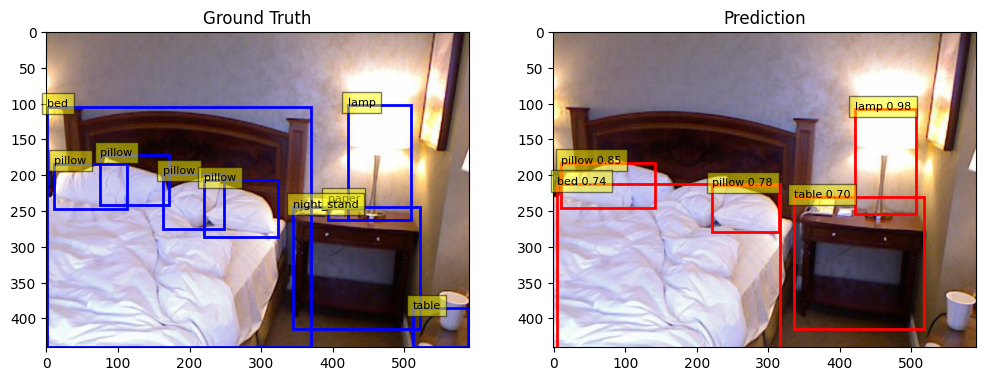

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Draw the image and the ground truth bounding boxes on the first subplot
ax[0].imshow(im)
for box, category_id in zip(gt_boxes, gt_classes):
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].text(box[0], box[1], id_to_name[category_id], fontsize=8,
                bbox=dict(facecolor='yellow', alpha=0.5))
ax[0].set_title('Ground Truth')

# Draw the outputs of the model on the second subplot
ax[1].imshow(im)
for box, category_id, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if score > 0.7:
        # Detach the box tensor and convert it to a NumPy array
        box = box.detach().cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(box[0], box[1], id_to_name[category_id.item()] + f' {score:.2f}', fontsize=8,
                    bbox=dict(facecolor='yellow', alpha=0.5))
ax[1].set_title('Prediction')

plt.show()

plt.show()